In [1]:
import pandas as pd
import numpy as np

In [2]:
#def rename_columns(path = "data/cifar10_cons.csv"):
def OSL_data_old(path = "data/exp2/IMDBtoken_pos2_val.csv"):
   df = pd.read_csv(path)
   df = df.drop(["Step"], axis='columns')
   print(df.shape)
   min_max = [col for col in list(df.columns) if "MIN" in col or "MAX" in col]
   df = df.drop(min_max, axis='columns')
   print(df.shape)

   not_all = [col for col in list(df.columns) if "\'first\'" in col or "\'everyother\'"  in col]
   print("not all", not_all)
   df = df.drop(not_all, axis='columns')
   df = df.dropna(axis = "columns")
   df = df.rename(columns={name: name.lower()[:-11] for name in list(df.columns)})

   imdb = True if "IMDB" in path else False
   vars = ["mamba", "diag","10000", "1024", "true"]
   bonus_vars = ["b", "c", "dt", "x"]
   final_vars = ["no_emb", "imdb","acc"]
   all_vars = vars + bonus_vars + final_vars
   num_vars = len(all_vars)
   old_names = list(df.columns)


   binary_data = np.zeros((len(df.columns), num_vars))
   for name_dix, name in enumerate(old_names):
      for var_idx, var in enumerate(vars):
         if var in name:
            binary_data[name_dix, var_idx] = 1.

         # get b,c,dt,x for s6
         if "s6" in name and "[" in name:
            subset = name.split(" ")[-1]
            for var_idx2, var in enumerate(bonus_vars):
               if var in subset:
                  binary_data[name_dix, len(vars) + var_idx2] = 1.

      # get acc and dataset
      acc = df[name].values[-1]
      binary_data[name_dix, -1] = acc
      if imdb:
         binary_data[name_dix, -2] = 1.

      if len(name.split(" ")) < 3 or not " " in name:
         binary_data[name_dix, -3] = 1.

   return binary_data, all_vars
# imdb_ols_data, all_vars = OSL_data(path="data/exp2/IMDBtoken_pos2_val.csv")
# cifar10_ols_data, _ = OSL_data(path = "data/exp2/CIFAR10cons_pos2_val.csv")

In [3]:
# def rename_columns(path = "data/cifar10_cons.csv"):
import pandas as pd
import numpy as np
def OSL_data(path="data/exp2/IMDBtoken_pos2_val.csv", test_or_val = "test"):
   #"test acc","train acc","val acc"
   df = pd.read_csv(path)
   print(df.shape)

   names = list(df["Name"])

   not_all = [idx for idx, name in enumerate(names) if "\'first\'" in name or "\'everyother\'" in name]
   print("not all", not_all)
   assert len(not_all) == 0, "there are fist and everyother"

   df = df[df.State == "finished"]
   # df = df.rename(columns={name: name.lower()[:-11] for name in list(df.columns)})

   names = [name.lower() for name in list(df["Name"])]
   imdb = True if "IMDB" in path else False
   vars = ["mamba", "diag", "10000", "1024", "true"]
   bonus_vars = ["b", "c", "dt", "x"]
   final_vars = ["no_emb", "imdb", "acc"]
   all_vars = vars + bonus_vars + final_vars
   num_vars = len(all_vars)
   # old_names = list(df.columns)

   binary_data = np.zeros((len(names), num_vars))
   for name_dix, name in enumerate(names):
      for var_idx, var in enumerate(vars):
         if var in name:
            binary_data[name_dix, var_idx] = 1.

         # get b,c,dt,x for s6
         if "s6" in name and "[" in name:
            subset = name.split(" ")[-1]
            for var_idx2, var in enumerate(bonus_vars):
               if var in subset:
                  binary_data[name_dix, len(vars) + var_idx2] = 1.

      # get acc and dataset
      acc = df[test_or_val+" acc"].values[-1]
      binary_data[name_dix, -1] = acc
      if imdb:
         binary_data[name_dix, -2] = 1.

      if len(name.split(" ")) < 3 or not " " in name:
         binary_data[name_dix, -3] = 1.

   return binary_data, all_vars


imdb_ols_data, all_vars = OSL_data(path="data/exp2/IMDBtoken_pos2_val.csv")
cifar10_ols_data, _ = OSL_data(path = "data/exp2/CIFAR10cons_pos2_val.csv")

imdb_ols_data, all_vars = OSL_data_old(path="data/exp2/IMDBtoken_pos2_val_OLD.csv")
cifar10_ols_data, _ = OSL_data_old(path = "data/exp2/CIFAR10cons_pos2_val_OLD.csv")

(43, 22)
not all []
(45, 22)
not all []
(15, 117)
(15, 39)
not all []
(25, 123)
(25, 41)
not all []


In [4]:
#print(list(zip(all_vars, imdb_ols_data.mean(axis=0))))
print(all_vars)
print("cifar", cifar10_ols_data.mean(axis=0).round(2))
print("imdb", imdb_ols_data.mean(axis=0).round(2))
combined = np.vstack((cifar10_ols_data, imdb_ols_data))
print("combined", combined.mean(axis=0).round(2))
print("combined shape:", combined.shape)

#print(cifar10_ols_data.round(2))

['mamba', 'diag', '10000', '1024', 'true', 'b', 'c', 'dt', 'x', 'no_emb', 'imdb', 'acc']
cifar [0.71 0.59 0.44 0.56 0.44 0.29 0.27 0.27 0.2  0.07 0.   0.76]
imdb [0.77 0.46 0.44 0.56 0.38 0.33 0.33 0.26 0.21 0.1  1.   0.79]
combined [0.74 0.52 0.44 0.56 0.41 0.31 0.3  0.26 0.2  0.09 0.49 0.78]
combined shape: (80, 12)


In [5]:
import statsmodels.api as sm
y = combined[:,-1]
x = combined[:,:-1]
x = sm.add_constant(x, has_constant="raise")
mod = sm.OLS(y,x)
fit = mod.fit()
print(fit.params)
fit.summary(xname=["cons"]+all_vars[:-1])


[ 0.72604217  0.04929428 -0.03627919  0.02234766  0.0634952  -0.02913717
 -0.01558759  0.00970536 -0.01829715 -0.03319686  0.06803141  0.01828756]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     8.602
Date:                Wed, 01 May 2024   Prob (F-statistic):           2.70e-09
Time:                        10:58:07   Log-Likelihood:                 145.32
No. Observations:                  80   AIC:                            -266.6
Df Residuals:                      68   BIC:                            -238.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons           0.7260      0.024     30.461      0.000       0.678       0.774
mamba          0.0493      0.013      3.743      0.000       0.023       0.076
diag          -0.0363      0.020     -1.855      0.068      -0.075       0.003
10000          0.0223      0.011      2.108      0.039       0.001       0.044
1024           0.0635      0.011      5.790      0.000       0.042       0.085
true          -0.0291      0.011     -2.749      0.008      -0.050      -0.008
b             -0.0156      0.023     -0.687      0.495      -0.061       0.030
c              0.0097      0.021      0.454      0.651      -0.033       0.052
dt            -0.0183      0.016     -1.177      0.243      -0.049       0.013
x             -0.0332      0.015     -2.210      0.030      -0.063      -0.003
no_emb         0.0680      0.020      3.362      0.001       0.028       0.108
imdb           0.0183      0.010      1.876      0.065      -0.001       0.038
==============================================================================
Omnibus:                       12.698   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                4.562
Skew:                          -0.281   Prob(JB):                        0.102
Kurtosis:                       1.974   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[ 9  3  0  2 10  6  5  7  4  8  1]
[ 0.04929428 -0.03627919  0.02234766  0.0634952  -0.02913717 -0.01558759
  0.00970536 -0.01829715 -0.03319686  0.06803141  0.01828756]


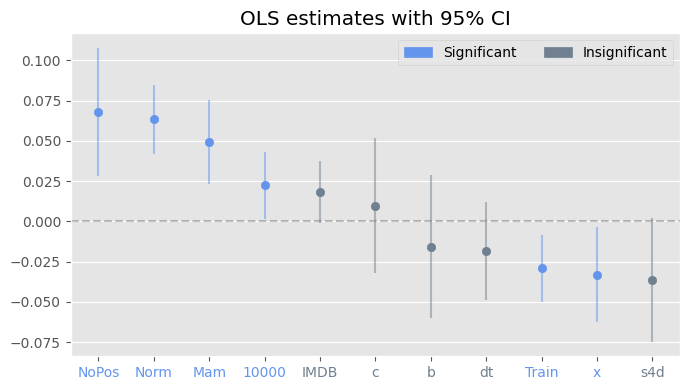

In [6]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
num_vars = len(fit.params[1:])

params_ = np.array(fit.params[1:])
all_vars_ = np.array(["Mam", "s4d", "10000", "Norm", "Train", "b", "c", "dt", "x", "NoPos", "IMDB"])#np.array(all_vars[:-1])
se_ = np.array(fit.bse[1:])
sorted_args = np.argsort(params_)[::-1]
print(sorted_args)
print(params_)

params = params_[sorted_args]
se = se_[sorted_args]
all_var_names = all_vars_[sorted_args]


colors = []
plt.figure(figsize=(7,4))     
ax = plt.subplot(111)
for i in range(num_vars):
   if ((params[i]-1.96*se[i] < 0) and  (params[i]+1.96*se[i] < 0))  or ((params[i]-1.96*se[i] > 0) and  (params[i]+1.96*se[i] > 0)):
      color="cornflowerblue"
      alpha=1.
   else:
      color="slategray"
      alpha=0.6
   colors.append(color)
   plt.scatter(i, params[i], color=color)
   plt.vlines(i, params[i]-1.96*se[i], params[i]+1.96*se[i], color=color, alpha=0.5)

plt.xticks(range(num_vars), all_var_names)
for xtick, color in zip(ax.get_xticklabels(), colors):
    xtick.set_color(color)

import matplotlib.patches as mpatches
red_patch = [
           mpatches.Patch(color='cornflowerblue', label='Significant'),
           mpatches.Patch(color='slategray', label='Insignificant'),
          ]

plt.legend(handles=red_patch, ncol=2)

plt.axhline(0, color="gray", alpha=0.5, linestyle="--")
plt.grid(axis="x")
plt.title("OLS estimates with 95% CI")
plt.tight_layout()
plt.savefig(f"data/exp2/ols_coef_ci_pos_emb.png", dpi=200)


In [7]:
all_vars__ = np.array(["Mam", "s4d", "10000", "Norm", "Train", "b", "c", "dt", "x", "NoPos", "IMDB", "Acc"])

df = np.vstack((np.array(all_vars__), 
                imdb_ols_data.sum(axis=0).astype(int), 
                cifar10_ols_data.sum(axis=0).astype(int),
                combined.sum(axis=0).astype(int), 
                combined.mean(axis=0).round(3))) 
df

array([['Mam', 's4d', '10000', 'Norm', 'Train', 'b', 'c', 'dt', 'x',
        'NoPos', 'IMDB', 'Acc'],
       ['30', '18', '17', '22', '15', '13', '13', '10', '8', '4', '39',
        '30'],
       ['29', '24', '18', '23', '18', '12', '11', '11', '8', '3', '0',
        '31'],
       ['59', '42', '35', '45', '33', '25', '24', '21', '16', '7', '39',
        '62'],
       ['0.738', '0.525', '0.438', '0.562', '0.412', '0.312', '0.3',
        '0.262', '0.2', '0.088', '0.488', '0.778']], dtype='<U32')

In [8]:
df[1,-1] = imdb_ols_data.mean(axis=0).round(3)[-1]
df[2,-1] = cifar10_ols_data.mean(axis=0).round(3)[-1]
df[3,-1] = None
df

array([['Mam', 's4d', '10000', 'Norm', 'Train', 'b', 'c', 'dt', 'x',
        'NoPos', 'IMDB', 'Acc'],
       ['30', '18', '17', '22', '15', '13', '13', '10', '8', '4', '39',
        '0.793'],
       ['29', '24', '18', '23', '18', '12', '11', '11', '8', '3', '0',
        '0.764'],
       ['59', '42', '35', '45', '33', '25', '24', '21', '16', '7', '39',
        'None'],
       ['0.738', '0.525', '0.438', '0.562', '0.412', '0.312', '0.3',
        '0.262', '0.2', '0.088', '0.488', '0.778']], dtype='<U32')